In [20]:
# importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [21]:
# setting default constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [22]:
# loading the data in the tf input pipeline
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/vulcan/Desktop/Blight Buster/version 1.0.0/blight-buster/data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7930 files belonging to 3 classes.


In [23]:
class_names = dataset.class_names
class_names

['potato_early_blight', 'potato_healthy', 'potato_late_blight']

In [24]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 2 1 1 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 1 2]


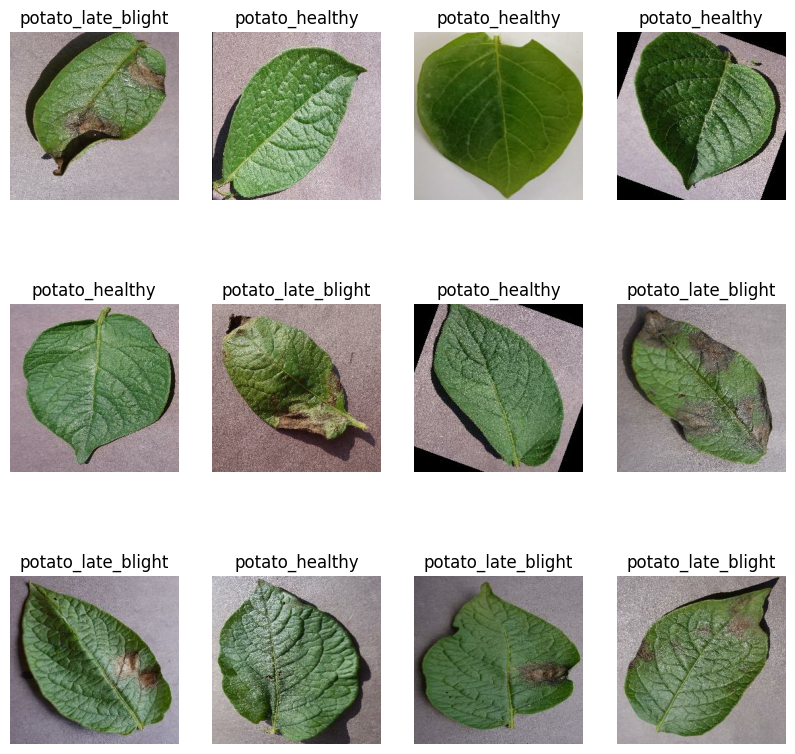

In [25]:
# viusualising the data
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [26]:
# creating the train, test, and validation split function
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

173
37
38


In [29]:
# caching and prefetching for training optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
# data augmentation to increase input data
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])